<a href="https://colab.research.google.com/github/Gabriele90/health-data-science/blob/main/Classification_algorithms_in_Alzheimer's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Summary***

Although neuroimaging, genetic, and cerebrospinal measurements show promising results, high costs and invasiveness hinder their widespread use. Predicting cognitive impairment using easy-to-collect variables by noninvasive methods for community-dwelling elderly is useful prior to conducting such a comprehensive
evaluation. This study aimed to develop a machine learning-based predictive model for future cognitive
impairment.

This study demonstrated that a machine learning-based predictive classification model might be used
to screen future cognitive impairment using variables, which are commonly collected in community
health care institutions. With efforts of enhancing the predictive performance, such a machine learningbased approach can further contribute to the improvement of the cognitive function in community
elderly.


***Importing Libraries***

In [2]:
import pandas as pd # used to load, manipulate the data and for one-hot encoding
import numpy as np # data manipulation
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample # for downsample the dataset
from sklearn.model_selection import train_test_split # for splitting the dataset into train and test split
from sklearn.preprocessing import scale # scale and center the data
from sklearn.svm import SVC # will make a SVM for classification
from sklearn.model_selection import GridSearchCV # will do the cross validation
from sklearn.metrics import plot_confusion_matrix # will draw the confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc
import seaborn as sns

***Importing Data***

The dataset contains cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults.

In [3]:
data = pd.read_csv("/content/oasis_longitudinal.csv")

***Data exploration***

In [4]:
pd.set_option('display.max_columns', None) # will show the all columns with pandas dataframe
pd.set_option('display.max_rows', None) # will show the all rows with pandas dataframe

In [5]:
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [6]:
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [7]:
median = data['MMSE'].median()
data['MMSE'].fillna(median, inplace=True)
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           0
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [8]:
median = data['SES'].median()
data['SES'].fillna(median, inplace=True)
data.isnull().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

***Feature engineering***

In [9]:
data['M/F'] = [1 if each == "M" else 0 for each in data['M/F']]
data['Group'] = [1 if each == "Demented" or each == "Converted" else 0 for each in data['Group']]
# data['Group'] = data['Group'].replace(['Converted'], ['Demented']) # Target variable
# data['Group'] = data['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    int64  
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    int64  
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         373 non-null    float64
 10  MMSE        373 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(7), object(3)
memory usage: 43.8+ KB


***Data correlation***

In [10]:
correlation_matrix = data.corr()
data_corr = correlation_matrix['Group'].sort_values(ascending=False)
data_corr

Group       1.000000
CDR         0.778049
M/F         0.222146
SES         0.038870
ASF         0.032495
Age        -0.005941
eTIV       -0.042700
Visit      -0.095507
MR Delay   -0.120638
EDUC       -0.193060
nWBV       -0.311346
MMSE       -0.520553
Name: Group, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ea5c60dd0>,
      dtype=object)

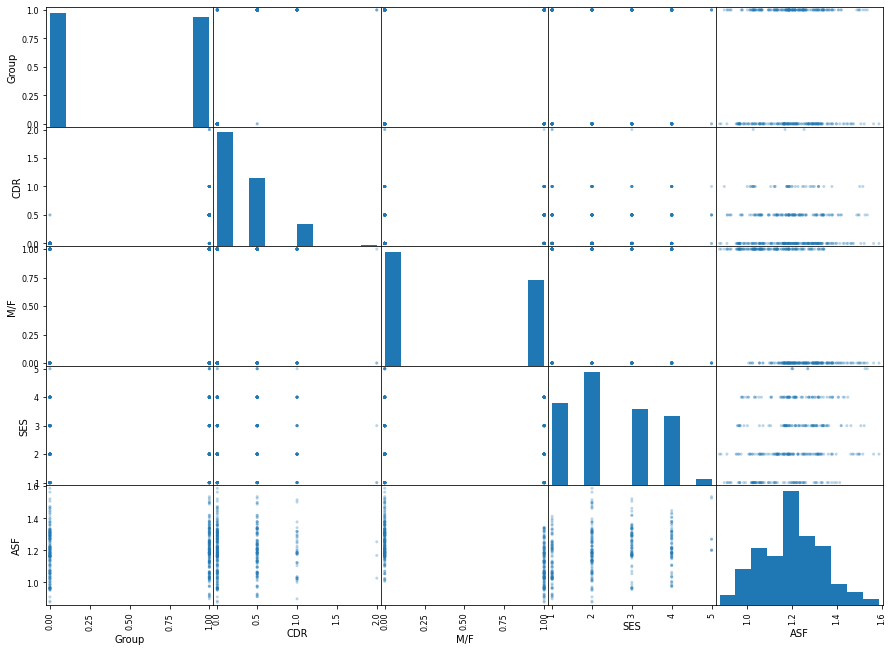

In [11]:
from pandas.plotting import scatter_matrix

attributes = ["Group", "CDR", "M/F", "SES", "ASF"]

scatter_matrix(data[attributes], figsize=(15, 11), alpha=0.3)

In [12]:
import plotly.express as px

fig = px.scatter(data, x='Group', y='SES', color='Group')
fig.show()

In [13]:
fig = px.scatter(data, x='Group', y='Age', color='Group')
fig.show()

In [14]:
fig = px.scatter(data, x='Group', y='ASF', color='Group')
fig.show()

***Data splitting***

In [15]:
y = data['Group'].values
X = data[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]

Trainig test distribution (no stratified sampling)

In [16]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size= 0.30, random_state=42)

df_ytrain = pd.DataFrame(y_trainval)
df_ytest = pd.DataFrame(y_test)

print('In Training Split:')
print(df_ytrain[0].value_counts())

print('\nIn Testing Split:')
print(df_ytest[0].value_counts())

In Training Split:
0    138
1    123
Name: 0, dtype: int64

In Testing Split:
1    60
0    52
Name: 0, dtype: int64


Trainig test distribution (using stratified sampling)

In [17]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size= 0.30, random_state=42, stratify=y)


df_ytrain = pd.DataFrame(y_trainval)
df_ytest = pd.DataFrame(y_test)

print('In Training Split:')
print(df_ytrain[0].value_counts())

print('\nIn Testing Split:')
print(df_ytest[0].value_counts())

In Training Split:
0    133
1    128
Name: 0, dtype: int64

In Testing Split:
0    57
1    55
Name: 0, dtype: int64


***Data scaling***

In [18]:
# here StandardScaler() means z = (x - u) / s
scaler = StandardScaler().fit(X_trainval)
#scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [19]:
X_trainval_scaled

array([[-0.85350854,  0.7106201 ,  0.55804894, ..., -0.13381404,
        -0.95888774,  0.02412616],
       [ 1.17163445,  2.06344173, -0.86640849, ..., -1.00199796,
        -1.45743296,  1.04625791],
       [-0.85350854,  0.98118442,  0.55804894, ..., -0.17460121,
        -1.24751918,  0.06889106],
       ...,
       [-0.85350854,  0.03420928,  1.27027765, ..., -0.93790384,
        -0.01427575,  0.95672812],
       [-0.85350854, -0.23635504, -0.86640849, ..., -1.82939471,
         0.2743557 ,  2.25491004],
       [-0.85350854,  0.16949145,  1.27027765, ..., -1.39821612,
         0.43179103,  1.59089745]])

In [20]:
X_trainval.describe()

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.421456,76.747126,14.432950,2.524904,27.226054,1482.965517,0.731544,1.198766
std,0.494741,7.406159,2.813482,1.125044,3.847908,171.952349,0.038184,0.134291
min,0.000000,60.000000,6.000000,1.000000,4.000000,1106.000000,0.644000,0.883000
25%,0.000000,71.000000,12.000000,2.000000,27.000000,1359.000000,0.703000,1.118000
50%,0.000000,77.000000,14.000000,2.000000,29.000000,1460.000000,0.733000,1.202000
75%,1.000000,82.000000,16.000000,3.000000,30.000000,1569.000000,0.758000,1.291000
max,1.000000,96.000000,20.000000,5.000000,30.000000,1987.000000,0.837000,1.587000


***Data Visualization***

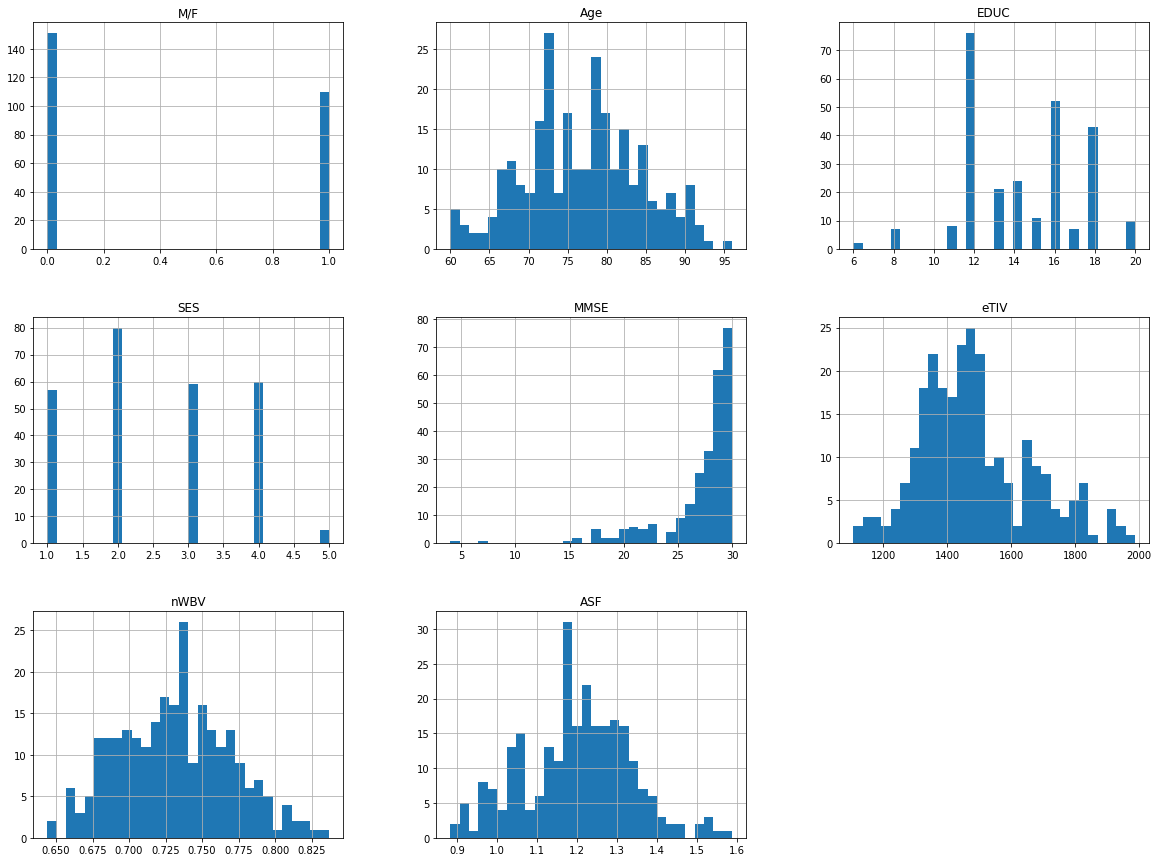

In [21]:
X_trainval.hist(bins=30, figsize=(20,15))
plt.show()

In [22]:
import plotly.express as px

x = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

fig = px.scatter(X_trainval, x='eTIV')
fig.show()

***Model Training***

We're going to analyze different classification algorithms and see how they perform, assessing the correspective model scores.

***Logistic regression classifier***

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc

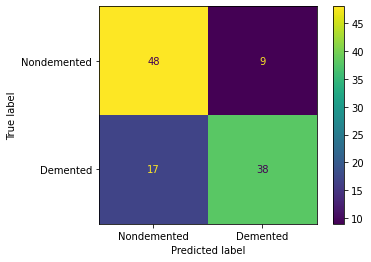

In [39]:
log_reg_model = LogisticRegression().fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(log_reg_model, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [40]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

log_reg_model = LogisticRegression().fit(X_trainval_scaled, y_trainval)
train_score = log_reg_model.score(X_trainval_scaled, y_trainval)
test_score = log_reg_model.score(X_test_scaled, y_test)
scores = log_reg_model.score(X_test_scaled, y_test)
y_predict = log_reg_model.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(fpr, tpr)


print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  0.8122605363984674
Test accuracy  0.7678571428571429
Test recall 0.6909090909090909
Test AUC 0.7665071770334928


***Hyperparameter optimization***

In [41]:
param_grid = {'penalty': ['l1','l2'], 
               'C': [0.001,0.01,0.1,1, 2, 3, 5, 10,100,1000]}

optimal_params = GridSearchCV(LogisticRegression(),
                             param_grid,
                             cv=5, # we are taking 5-fold as in k-fold cross validation
                             scoring='accuracy', # try the other scoring if have time
                             verbose=0,
                             n_jobs=-1)

optimal_params.fit(X_trainval_scaled, y_trainval)
print(optimal_params.best_params_)

{'C': 1, 'penalty': 'l2'}


In [43]:
best_C = optimal_params.best_params_['C']
best_penalty = optimal_params.best_params_['penalty']

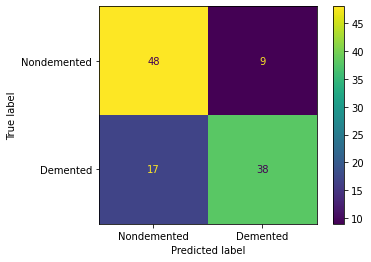

In [44]:
log_reg_model = LogisticRegression(C=best_C, penalty=best_penalty).fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(log_reg_model, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [45]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

best_log_reg_model = LogisticRegression(C=best_C, penalty=best_penalty).fit(X_trainval_scaled, y_trainval)
train_score = best_log_reg_model.score(X_trainval_scaled, y_trainval)
test_score = best_log_reg_model.score(X_test_scaled, y_test)
y_predict = best_log_reg_model.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
lgr_fpr, lgr_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(lgr_fpr, lgr_tpr)

print("Train accuracy with Logistec regression:", train_score)
print("Test accuracy with Logistec regression:", test_score)
print("Test recall with Logistec regression:", test_recall)
print("Test AUC with Logistec regression:", test_auc)

Train accuracy with Logistec regression: 0.8122605363984674
Test accuracy with Logistec regression: 0.7678571428571429
Test recall with Logistec regression: 0.6909090909090909
Test AUC with Logistec regression: 0.7665071770334928


***Support Vector Machine***

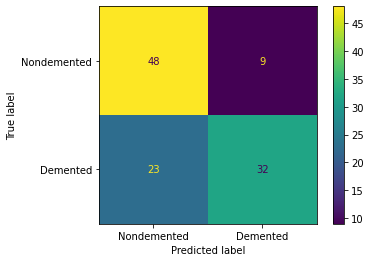

In [23]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [24]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval_scaled, y_trainval)
test_score = clf_svm.score(X_test_scaled, y_test)
y_predict = clf_svm.predict(X_test_scaled)

test_recall = recall_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(fpr, tpr)


print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  0.8735632183908046
Test accuracy  0.7142857142857143
Test recall 0.5818181818181818
Test AUC 0.7119617224880381


***Hyperparameter optimization***

In [25]:
param_grid = [
    {'C': [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 80, 100],
    'gamma': ['scale', 0.5, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
]

optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv=5, # we are taking 5-fold as in k-fold cross validation
                             scoring='accuracy', # try the other scoring if have time
                             verbose=0,
                             n_jobs=-1)

optimal_params.fit(X_trainval_scaled, y_trainval)
print(optimal_params.best_params_)

{'C': 3, 'gamma': 1, 'kernel': 'rbf'}


In [26]:
C = optimal_params.best_params_['C']
gamma = optimal_params.best_params_['gamma']
kernel = optimal_params.best_params_['kernel']

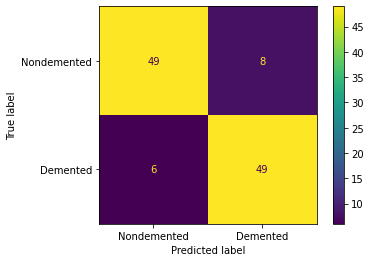

In [27]:
clf_svm = SVC(random_state=42, C=C, gamma=gamma, kernel=kernel)
clf_svm.fit(X_trainval_scaled, y_trainval)

plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [28]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval_scaled, y_trainval)
test_score = clf_svm.score(X_test_scaled, y_test)
y_predict = clf_svm.predict(X_test_scaled)

test_recall = recall_score(y_test, y_predict)
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(svm_fpr, svm_tpr)


print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  1.0
Test accuracy  0.875
Test recall 0.8909090909090909
Test AUC 0.8752791068580542


Random forest classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

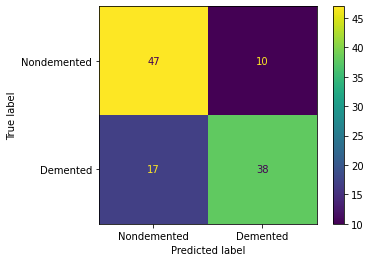

In [30]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(rfc, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [31]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = rfc.score(X_trainval_scaled, y_trainval)
test_score = rfc.score(X_test_scaled, y_test)
y_predict = rfc.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(fpr, tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  1.0
Test accuracy  0.7589285714285714
Test recall 0.6909090909090909
Test AUC 0.7577352472089314


Hyperparameter optimization

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = range(1,10)

# measure the quality of a split
criterion = ['gini']

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [33]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'criterion': criterion,
               'bootstrap': bootstrap}

In [34]:
optimal_params = GridSearchCV(RandomForestClassifier(),
                             param_grid,
                             cv=5, # we are taking 5-fold as in k-fold cross validation
                             scoring='accuracy', # try the other scoring if have time
                             verbose=0,
                             n_jobs=-1)

optimal_params.fit(X_trainval_scaled, y_trainval)
print(optimal_params.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 90}


In [35]:
bootstrap = optimal_params.best_params_['bootstrap']
criterion = optimal_params.best_params_['criterion']
max_depth = optimal_params.best_params_['max_depth']
max_features = optimal_params.best_params_['max_features']
n_estimators = optimal_params.best_params_['n_estimators']

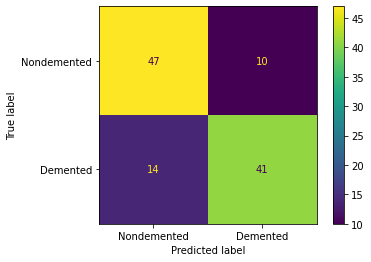

In [36]:
rfc = RandomForestClassifier(n_estimators=n_estimators, 
                             max_features=max_features, 
                             max_depth=max_depth, 
                             criterion=criterion,
                             bootstrap=bootstrap,
                             random_state=42)

rfc.fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(rfc, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [37]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = rfc.score(X_trainval_scaled, y_trainval)
test_score = rfc.score(X_test_scaled, y_test)
y_predict = rfc.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(rfc_fpr, rfc_tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  1.0
Test accuracy  0.7857142857142857
Test recall 0.7454545454545455
Test AUC 0.7850079744816587


***Decision Tree classifier***

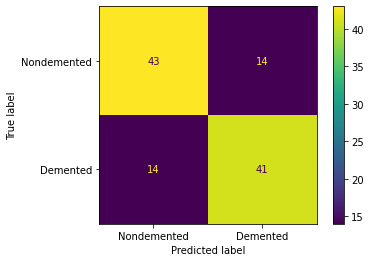

In [46]:
dtc_model = DecisionTreeClassifier().fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(dtc_model, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [48]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

dtc_model = DecisionTreeClassifier().fit(X_trainval_scaled, y_trainval)
train_score = dtc_model.score(X_trainval_scaled, y_trainval)
test_score = dtc_model.score(X_test_scaled, y_test)
y_predict = dtc_model.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(fpr, tpr)

print("Train accuracy with DecisionTreeClassifier:", train_score)
print("Test accuracy with DecisionTreeClassifier:", test_score)
print("Test recall with DecisionTreeClassifier:", test_recall)
print("Test AUC with DecisionTreeClassifier:", test_auc)

Train accuracy with DecisionTreeClassifier: 1.0
Test accuracy with DecisionTreeClassifier: 0.7321428571428571
Test recall with DecisionTreeClassifier: 0.6909090909090909
Test AUC with DecisionTreeClassifier: 0.7314194577352471


***Hyperparameter optimization***

In [ ]:
param_grid = {'criterion': ['gini'], 
              'max_depth': range(1,10)}

optimal_params = GridSearchCV(DecisionTreeClassifier(),
                             param_grid,
                             cv=5, # we are taking 5-fold as in k-fold cross validation
                             scoring='accuracy', # try the other scoring if have time
                             verbose=0,
                             n_jobs=-1)

optimal_params.fit(X_trainval_scaled, y_trainval)
print(optimal_params.best_params_)

In [ ]:
criterion = optimal_params.best_params_['criterion']
max_depth = optimal_params.best_params_['max_depth']

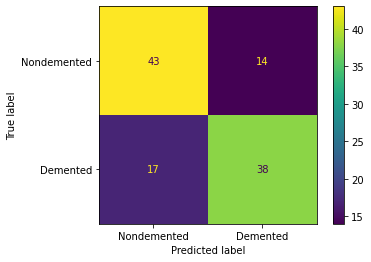

In [49]:
dtc_model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth).fit(X_trainval_scaled, y_trainval)

# for test there are 94 cases
plot_confusion_matrix(dtc_model, 
                      X_test_scaled, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

In [50]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

dtc_model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth).fit(X_trainval_scaled, y_trainval)
train_score = dtc_model.score(X_trainval_scaled, y_trainval)
test_score = dtc_model.score(X_test_scaled, y_test)
y_predict = dtc_model.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(dt_fpr, dt_tpr)

print("Train accuracy with DecisionTreeClassifier:", train_score)
print("Test accuracy with DecisionTreeClassifier:", test_score)
print("Test recall with DecisionTreeClassifier:", test_recall)
print("Test AUC with DecisionTreeClassifier:", test_auc)

Train accuracy with DecisionTreeClassifier: 0.9770114942528736
Test accuracy with DecisionTreeClassifier: 0.75
Test recall with DecisionTreeClassifier: 0.7090909090909091
Test AUC with DecisionTreeClassifier: 0.7492822966507177


***Plottiug ROC and comparing AUC***

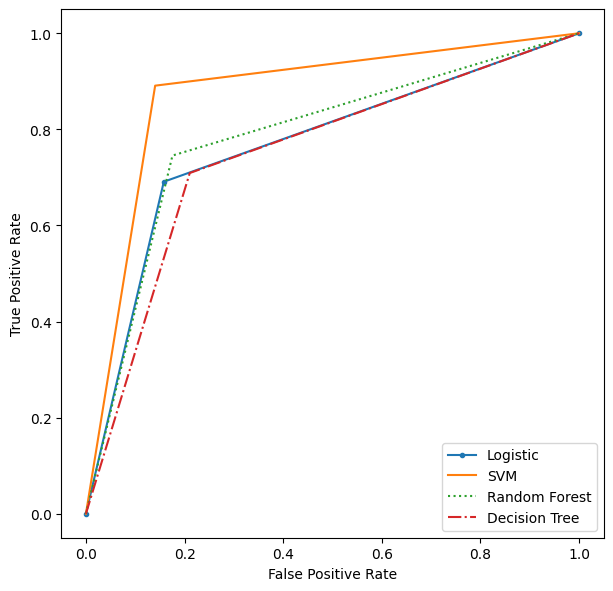

In [53]:
plt.figure(figsize=(7, 7), dpi=100)
plt.plot(lgr_fpr, lgr_tpr, marker='.', label='Logistic')
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM')
plt.plot(rfc_fpr, rfc_tpr, linestyle=':', label='Random Forest')
plt.plot(dt_fpr, dt_tpr, linestyle='-.', label='Decision Tree')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()